# Model: DLinear (Decomposition Linear)  - Stock Token: ITD - Train/Test/Vaildation: 80/10/10
- Dataset: 1252 rows x 7 column (01/03/2019 - 01/03/2024)
- Epochs: 200, Batch-size: 32, Learning-rate: 0.001
- Sequence length: 60, Predict length: 1
----
### Model evaluation (Test set)
- RMSE:  300.646179  
- MAE:   230.052994  
- MAPE:    0.021066 

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import display, Markdown

# Preprocessing

In [32]:
stocks=['FPT','CMG','ITD']
targets=['close']
train_test_split = ["721", "622", "811"] #Percent of for train, test, validation

project_path=os.getcwd()
data_path=os.path.join(project_path,'data\\')
processing_output=os.path.join(project_path,'processing_output\\')

os.makedirs(processing_output, exist_ok = True)

# Create sequences
T = 60 # ----> lookback
TF = 1 # ----> predict
batch_size = 32
learning_rate = 0.001
epochs = 200
configs = {
    'seq_len': T,
    'pred_len': TF,
    'enc_in': 1,
    'individual': False
}

data_set = {1: "train", 2: "test", 3: "validation"}
stock_id = 2 # 0: FPT, 1: CMG, 2: ITD
n_split = 2 # 0: 721, 1: 622, 2: 811

In [33]:
def getData(index):
  df = pd.read_csv(f"../../Dataset/{stocks[index]}_stock.csv", index_col="time")
  return df[[targets[0]]]

In [34]:
df = getData(stock_id)

In [35]:
def normalizationMinMax(df, data_set_index):
    """
  Params:
      * df -- DataFrame:        Dataframe need to be scaled
      * data_set_index -- int:  A number to recognize that dataset is train/testvalidation
  Returns:
      * scaler:     used for future inverse-transform
      * df_scaled:  df after normalization

  """
    scaler = MinMaxScaler()
    norm_set = data_set[data_set_index]

    processes_folder = f"{processing_output}/{stocks[stock_id]}"
    os.makedirs(processes_folder, exist_ok=True)

    if norm_set == "train": 
        scaler.fit(df)
        series = scaler.transform(df)
        #neu du lieu la tap train, ham se tien hanh fit() va transform() dua tren tap train
        df_scaled = pd.DataFrame(data=series, columns = df.columns)
        out_scaler_file = os.path.join(processing_output, f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{norm_set}_scalerMinMaxNorm.save")
        os.makedirs(os.path.dirname(out_scaler_file), exist_ok=True)
        joblib.dump(scaler, out_scaler_file)
        # sau do luu lai scaler de su dung cho cac tap test va validation
        print(os.path.exists(out_scaler_file))

    else:
        #neu du lieu la tap test hoac validation, ham se su dung scaler da duoc fit() tu tap train
        scaler = joblib.load(os.path.join(processing_output, f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_train_scalerMinMaxNorm.save"))
        series = scaler.transform(df)
        df_scaled = pd.DataFrame(data = series, columns = df.columns)

    out_file = os.path.join(processing_output, f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{norm_set}_scaler.xlsx")
    
    df_scaled.to_excel(out_file, float_format='%.5f')
    print(out_file)
    return df_scaled,scaler

In [36]:
n_observations = df.shape[0]

train_ratio = 0.7
test_ratio = 0.2

train_size = int(n_observations*train_ratio)
test_size = int(n_observations*test_ratio)
val_size = n_observations - train_size - test_size

train = df[:train_size]
test = df[train_size: train_size + test_size]
val = df[-val_size:]

In [37]:
# MinMaxScaler
train_scaled, scaler = normalizationMinMax(train, 1)
test_scaled, scaler = normalizationMinMax(test, 2)
val_scaled, scaler = normalizationMinMax(val, 3)
train_scaled.head()

True
d:\VSCode\IS403_O22_HTCL_8\Model\DLinear\processing_output\ITD\811\close_train_scaler.xlsx
d:\VSCode\IS403_O22_HTCL_8\Model\DLinear\processing_output\ITD\811\close_test_scaler.xlsx
d:\VSCode\IS403_O22_HTCL_8\Model\DLinear\processing_output\ITD\811\close_validation_scaler.xlsx


,close
0,0.098076
1,0.110490
2,0.110490
3,0.114836
4,0.114836


# DLinear Model

In [38]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x
    
class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

In [39]:
class DLinear(nn.Module):
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs['seq_len']
        self.pred_len = configs['pred_len']

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs['individual']
        self.channels = configs['enc_in']

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [40]:
#load scaler
scaler = joblib.load(os.path.join(f"{processing_output}/{stocks[stock_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [41]:
# Load data
def load_data(subset = "train", stock_id = 0, n_split = 0):
    df = pd.read_excel(f"./processing_output/{stocks[stock_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx")
    return df['close'].values

In [42]:
train_data = load_data(subset="train", stock_id = stock_id, n_split = n_split)
test_data = load_data(subset="test", stock_id = stock_id, n_split = n_split)
val_data = load_data(subset="validation", stock_id = stock_id, n_split = n_split)

In [43]:
# Prepare sequences using the provided function
def create_sequences(seq_length, pred_length, train, test, val):
    # TRAIN
    data = train
    X, Y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x = data[i:i + seq_length]
        X.append(x)
        y = data[i + seq_length:i + seq_length + pred_length]
        Y.append(y)
    Xtrain = np.array(X).astype(float)
    Ytrain = np.array(Y).astype(float)
    
    # TEST
    data = np.concatenate([train[-seq_length:], test])
    X, Y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x = data[i:i + seq_length]
        X.append(x)
        y = data[i + seq_length:i + seq_length + pred_length]
        Y.append(y)
    Xtest = np.array(X).astype(float)
    Ytest = np.array(Y).astype(float)

    # VAL
    data = np.concatenate([test[-seq_length:], val])
    X, Y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x = data[i:i + seq_length]
        X.append(x)
        y = data[i + seq_length:i + seq_length + pred_length]
        Y.append(y)
    Xval = np.array(X).astype(float)
    Yval = np.array(Y).astype(float)

    return (torch.FloatTensor(Xtrain).unsqueeze(-1), torch.FloatTensor(Ytrain).unsqueeze(-1),
            torch.FloatTensor(Xtest).unsqueeze(-1), torch.FloatTensor(Ytest).unsqueeze(-1),
            torch.FloatTensor(Xval).unsqueeze(-1), torch.FloatTensor(Yval).unsqueeze(-1))

In [44]:
X_train, y_train, X_test, y_test, X_val, y_val = create_sequences(T, TF, train_data, test_data, val_data)

In [46]:
# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

In [47]:
# Initialize and train model
model = DLinear(configs)

def train_model(model, train_loader, num_epochs=epochs, lr=learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        if(epoch % 10 == 0):
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')

train_model(model, train_loader)

Epoch [1/200], Loss: 0.0372
Epoch [11/200], Loss: 0.0018
Epoch [21/200], Loss: 0.0008
Epoch [31/200], Loss: 0.0006
Epoch [41/200], Loss: 0.0005
Epoch [51/200], Loss: 0.0004
Epoch [61/200], Loss: 0.0004
Epoch [71/200], Loss: 0.0004
Epoch [81/200], Loss: 0.0004
Epoch [91/200], Loss: 0.0004
Epoch [101/200], Loss: 0.0003
Epoch [111/200], Loss: 0.0004
Epoch [121/200], Loss: 0.0004
Epoch [131/200], Loss: 0.0004
Epoch [141/200], Loss: 0.0004
Epoch [151/200], Loss: 0.0004
Epoch [161/200], Loss: 0.0004
Epoch [171/200], Loss: 0.0004
Epoch [181/200], Loss: 0.0004
Epoch [191/200], Loss: 0.0004


Predict function

In [48]:
def predict(model, input, output):
    model.eval()
    with torch.no_grad():
        forecast = model(input).squeeze().numpy()
        actual = output.squeeze().numpy()
    return forecast, actual

In [49]:
# Inverse transform the predictions and actual values
y_train_predictions, y_train_actuals = predict(model, X_train, y_train)
train_predictions = scaler.inverse_transform(y_train_predictions.reshape(-1, 1)).flatten()
train_actuals = scaler.inverse_transform(y_train_actuals.reshape(-1, 1)).flatten()

#Predict test set
y_test_predictions, y_test_actuals = predict(model, X_test, y_test)
# Inverse transform the predictions and actual values
test_predictions = scaler.inverse_transform(y_test_predictions.reshape(-1, 1)).flatten()
test_actuals = scaler.inverse_transform(y_test_actuals.reshape(-1, 1)).flatten()

# Predict validation set
y_val_predictions, y_val_actuals = predict(model, X_val, y_val)
# Inverse transform the predictions and actual values
val_predictions = scaler.inverse_transform(y_val_predictions.reshape(-1, 1)).flatten()
val_actuals = scaler.inverse_transform(y_val_actuals.reshape(-1, 1)).flatten()


# Convert to Pandas Series for easier handling
train_predicted_prices = pd.Series(train_predictions)
train_actual_prices = pd.Series(train_actuals)
test_predicted_prices = pd.Series(test_predictions)
test_actual_prices = pd.Series(test_actuals)
val_predicted_prices = pd.Series(val_predictions)
val_actual_prices = pd.Series(val_actuals)

Evaluate function

In [50]:
def evaluate(title, actual, predict):
    rmse = np.sqrt(mean_squared_error(actual, predict))
    mae = mean_absolute_error(actual, predict)
    mape = mean_absolute_percentage_error(actual, predict)

    metrics = pd.Series({
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }, name=title)

    return metrics

In [51]:
metrics_df = pd.concat([evaluate("test", test_actual_prices, test_predicted_prices), 
                        evaluate("val", val_actual_prices, val_predicted_prices)], axis=1)

print(metrics_df)

            test         val
RMSE  300.646179  230.142487
MAE   230.052994  168.383804
MAPE    0.021066    0.016720


In [52]:
def plot_predictions(predictions, actuals, type):
    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label='Actual Prices')
    plt.plot(predictions, label='Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title(f'Actual vs Predicted Stock Prices ({type} set)')
    plt.legend()
    plt.show()

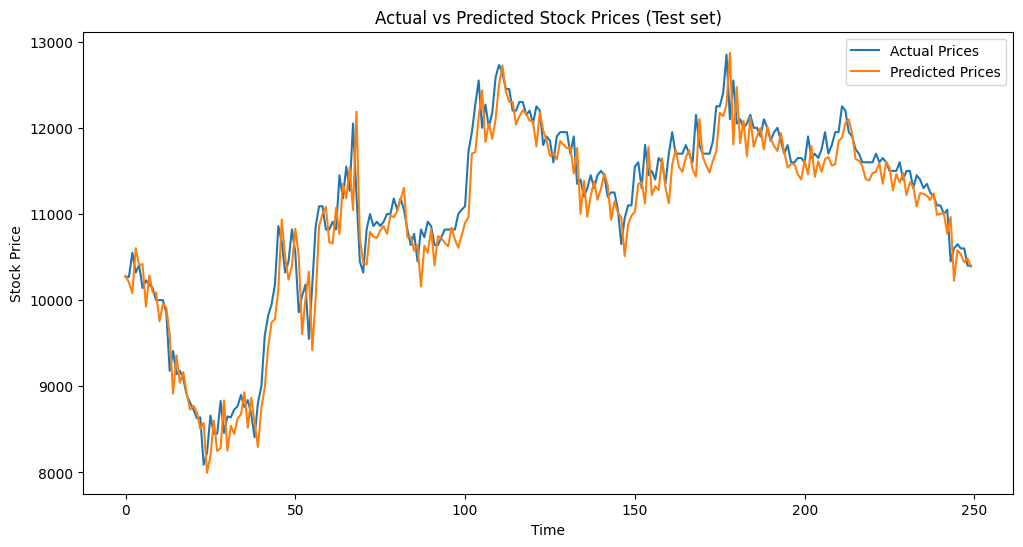

In [53]:
plot_predictions(test_predicted_prices, test_actual_prices, 'Test')

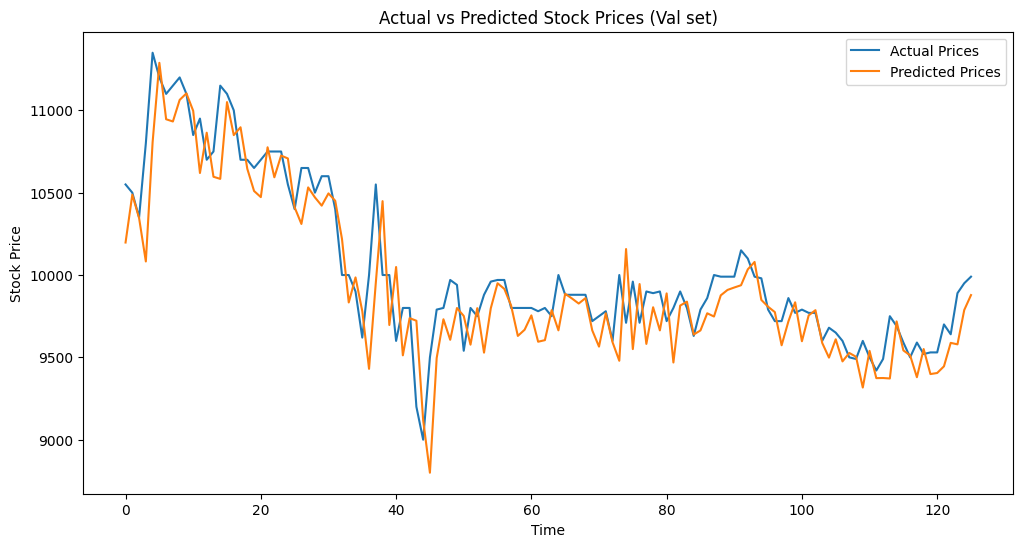

In [54]:
plot_predictions(val_predicted_prices, val_actual_prices, 'Val')

In [55]:
def forecast_next_n_days(model, initial_sequence, n_days, scaler):
    """
    Forecast the next n days using the trained DLinear model.
    
    Args:
    model (torch.nn.Module): Trained DLinear model.
    initial_sequence (numpy.ndarray): Initial input sequence to start the forecasting.
    n_days (int): Number of days to forecast.
    scaler (sklearn.preprocessing.MinMaxScaler): Scaler used for normalization.
    
    Returns:
    numpy.ndarray: Forecasted values for the next n days.
    """
    model.eval()
    forecasted = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(n_days):
        # Convert the current sequence to a tensor and add the channel dimension
        input_tensor = torch.FloatTensor(current_sequence).unsqueeze(0).unsqueeze(-1)
        
        # Make the prediction
        with torch.no_grad():
            prediction = model(input_tensor).squeeze().item()
        
        # Append the prediction to the forecasted list
        forecasted.append(prediction)
        
        # Update the current sequence
        current_sequence = np.append(current_sequence[1:], prediction)
    
    # Inverse transform the forecasted values
    forecasted = np.array(forecasted).reshape(-1, 1)
    forecasted = scaler.inverse_transform(forecasted).flatten()
    
    return forecasted

In [56]:
def plot_forecast(num_days, forecast):
    plt.figure(figsize=(10, 8))
    color_palette = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # train
    train_actual_prices = scaler.inverse_transform(train_data.reshape(-1, 1)).flatten()
    train_range = range(len(train_actual_prices))
    plt.plot(train_range, train_actual_prices, label="Actual Train", color = color_palette[0])

    # test
    test_actual_prices = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()
    test_range = range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices))
    plt.plot(test_range, test_actual_prices, label="Actual Test", color=color_palette[1])
    plt.plot(test_range, test_predicted_prices, label="Predict Test", linestyle="dotted", color=color_palette[2])

    # val
    val_actual_prices = scaler.inverse_transform(val_data.reshape(-1, 1)).flatten()
    val_range = range(len(train_actual_prices) + len(test_actual_prices), len(train_actual_prices) + len(test_actual_prices) + len(val_actual_prices))
    plt.plot(val_range, val_actual_prices, label="Actual Validation", color=color_palette[3])
    plt.plot(val_range, val_predicted_prices.squeeze(), label="Predict Validation", linestyle="dotted",color=color_palette[4])

    # # future
    future_range = range(len(train_actual_prices) + len(test_actual_prices) + len(val_actual_prices), len(train_actual_prices) + len(test_actual_prices) + len(val_actual_prices) + num_days)
    plt.plot(future_range, forecast.squeeze(), label=f"Predict {num_days} days", linestyle="dotted", color='black')

    plt.legend()
    plt.title(f"DLinear {stocks[stock_id]} -- {train_test_split[n_split]}")
    plt.show()

In [57]:
data = X_val[-1:].squeeze().numpy()

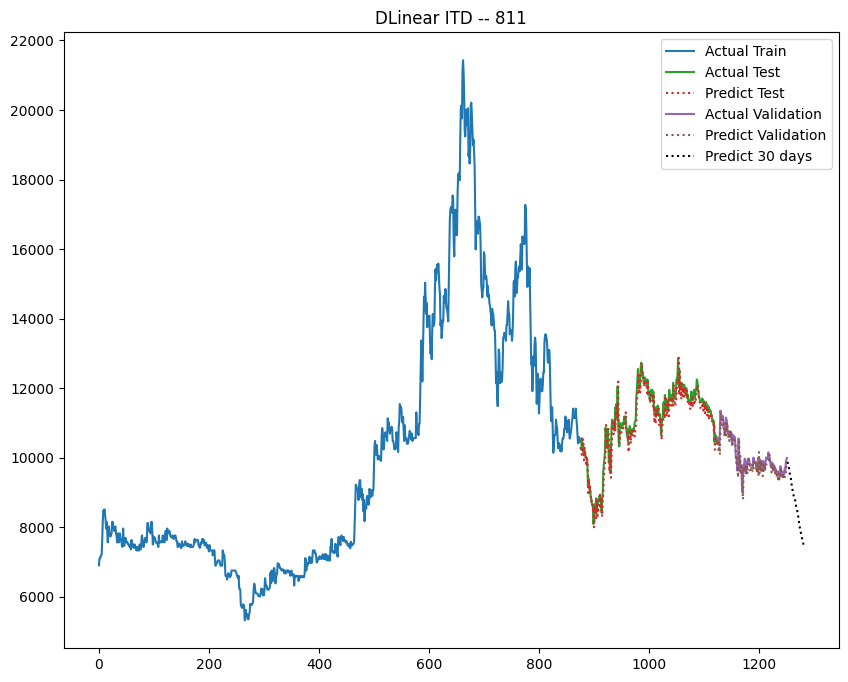

In [58]:
forecast = forecast_next_n_days(model, data, 30, scaler)
plot_forecast(30, forecast)

Forecast next 60 days

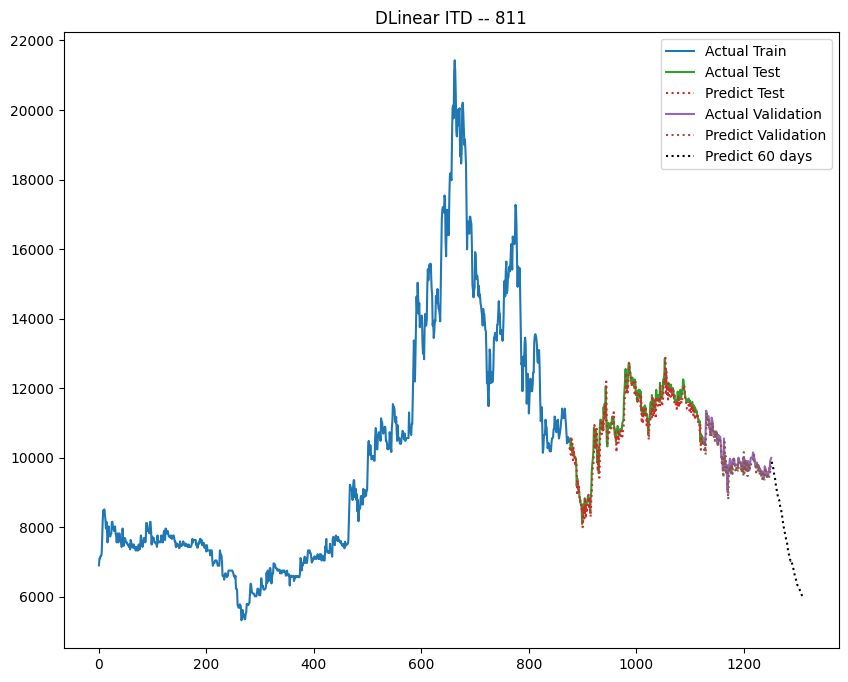

In [59]:
forecast = forecast_next_n_days(model, data, 60, scaler)
plot_forecast(60, forecast) # 60 days forecast

Forecast next 90 days

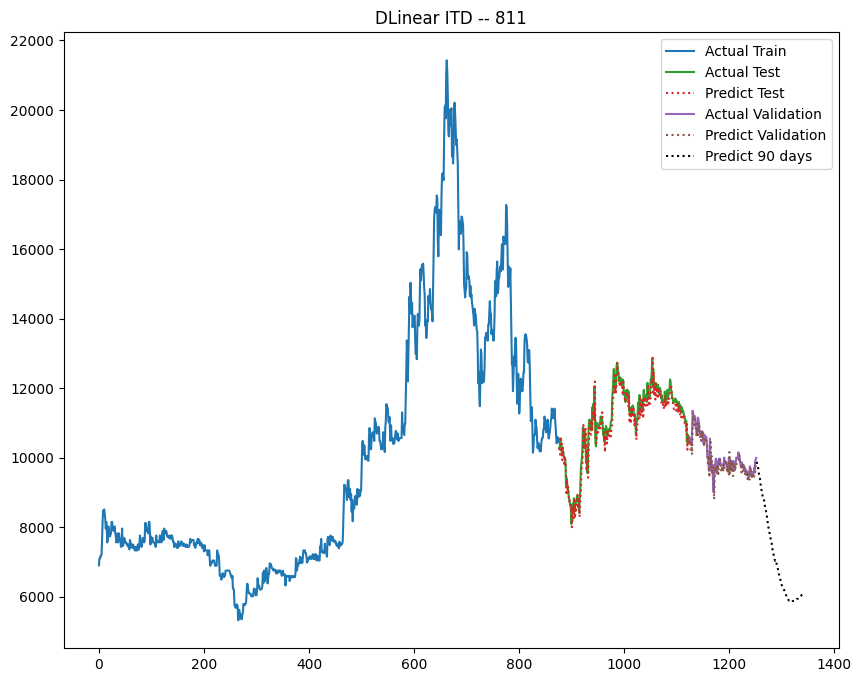

In [60]:
forecast = forecast_next_n_days(model, data, 90, scaler)
plot_forecast(90, forecast) # 90 days forecast